In [129]:
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re
import os
# import get_full_info
from sklearn import linear_model as lm, metrics, ensemble as ens
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier, XGBRegressor
import warnings

In [130]:
# df = get_full_info.df
# df = df[df['average_home_value'] != 0]
# df.to_csv("full_info.csv", index = False)
df = pd.read_csv("full_info.csv")
df['state'] = df['state'].apply(lambda x: re.sub('District Of Columbia', 'District of Columbia', x))
df = df[df['total_population'] >= 50000]

# df_latest = get_full_info.df_realtime
# df_latest = df_latest[df_latest['average_home_value'] != 0]
# df_latest.to_csv("latest_years.csv", index = False)
df_latest = pd.read_csv("latest_years.csv")
df_latest = df_latest.drop(columns = ['rent_in_three', 'three_year_growth'])
df_latest = df_latest[df_latest['total_population'] >= 50000]

In [131]:
len(set(df_latest['place'].values.tolist()))

878

In [132]:
df = pd.get_dummies(df, prefix = 'state', columns = ['state'])
df_latest = pd.get_dummies(df_latest, prefix = 'state', columns = ['state'])

In [133]:
for col in df.columns:
    if 'state' in col:
        df[col] = df[col].apply(lambda x: 1 if x == True else 0)

In [134]:
df_latest = df_latest[df_latest['year'] == df_latest['year'].max()]

In [135]:
print('mean current value: ', df_latest['average_home_value'].mean())
print('median current value: ', df_latest['average_home_value'].median())
print('25th percentile current value: ', np.percentile(df_latest['average_home_value'], 25))
print('number 200k or less: ', len(df_latest[df_latest['average_home_value'] <= 200000]))

mean current value:  441034.37650975893
median current value:  371733.4
25th percentile current value:  254659.86
number 200k or less:  108


In [136]:
df_latest_candidates = df_latest.sort_values(by = 'average_home_value').drop(columns = [x for x in df_latest.columns if x != 'place' and\
                                        x != 'year' and x != 'average_annual_rent' and\
                                        x != 'average_home_value' and x != 'total_population' and \
                                                                                        # '3' not in x and\
                                        'roi' not in x and 'vacancy' not in x])

df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('California')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('New York')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('Puerto Rico')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('Hawaii')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('Texas')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('Florida')]
df_latest_candidates = df_latest_candidates[df_latest_candidates['average_home_value'] <= 250000]
df_latest_candidates = df_latest_candidates[df_latest_candidates['total_population'] >= 100000]
df_latest_candidates = df_latest_candidates[df_latest_candidates['vacancy_growth_last_1_years'] < 0]
df_latest_candidates = df_latest_candidates[df_latest_candidates['vacancy_growth_last_3_years'] < df_latest_candidates['vacancy_growth_last_2_years']]
df_latest_candidates = df_latest_candidates[df_latest_candidates['vacancy_growth_last_2_years'] < df_latest_candidates['vacancy_growth_last_1_years']] 
df_latest_candidates.sort_values(by = 'vacancy_rate')

,year,place,average_annual_rent,average_home_value,total_population,vacancy_rate,vacancy_growth_last_1_years,vacancy_growth_last_2_years,vacancy_growth_last_3_years
112734,2022,Green Bay city - Wisconsin,9236.04,207376.55,106846,0.038405,-0.144985,-0.226759,-0.232500
104019,2022,Broken Arrow city - Oklahoma,12686.64,241907.74,114237,0.050297,-0.087292,-0.114080,-0.115551
97658,2022,Springfield city - Missouri,9197.04,180109.81,168873,0.050461,-0.082215,-0.175844,-0.342374
89221,2022,Joliet city - Illinois,12369.72,246262.48,150221,0.057373,-0.006929,-0.104471,-0.178888
95382,2022,Warren city - Michigan,11364.36,171685.02,138588,0.063109,-0.060786,-0.183544,-0.209669
86180,2022,Pueblo city - Colorado,10124.40,234415.38,111430,0.063935,-0.082590,-0.220793,-0.318264
94849,2022,Dearborn city - Michigan,13392.72,233492.03,108414,0.071170,-0.066968,-0.164560,-0.258202
99956,2022,Las Cruces city - New Mexico,9871.32,223360.87,111273,0.071916,-0.167887,-0.253698,-0.330282
108030,2022,Clarksville city - Tennessee,11916.48,239749.65,167882,0.073616,-0.098334,-0.236165,-0.293594
90300,2022,Fort Wayne city - Indiana,9245.64,176476.01,264514,0.074725,-0.070493,-0.137034,-0.179821


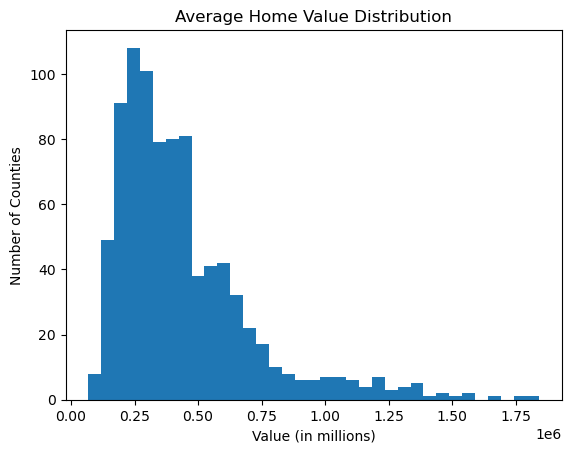

In [137]:
plt.hist(df_latest['average_home_value'], bins = 35)
plt.title("Average Home Value Distribution")
plt.xlabel("Value (in millions)")
plt.ylabel("Number of Counties")
plt.savefig("Home_Values_Dist")

In [138]:
df_latest['vacancy_rate'].mean()

0.07663215712259834

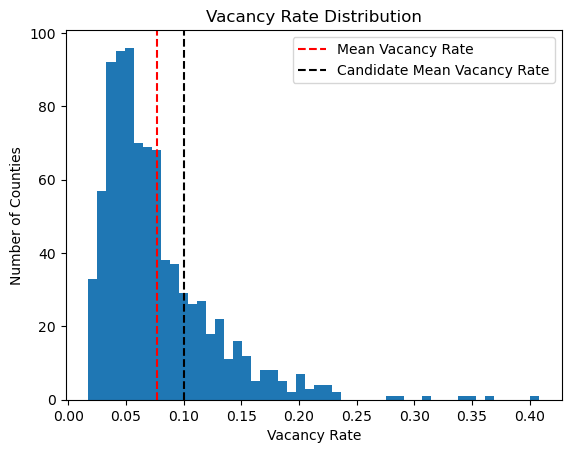

In [139]:
plt.hist(df_latest['vacancy_rate'], bins = 50)
plt.axvline(df_latest['vacancy_rate'].mean(), color = 'r', linestyle = 'dashed', label = 'Mean Vacancy Rate')
plt.axvline(df_latest_candidates['vacancy_rate'].mean(), color = 'k', linestyle = 'dashed', label = 'Candidate Mean Vacancy Rate')
plt.legend()
plt.title("Vacancy Rate Distribution")
plt.xlabel("Vacancy Rate")
plt.ylabel("Number of Counties")
plt.savefig("Vacancy_Dist")

In [140]:
print('mean current vacancy rate: ', df_latest['vacancy_rate'].mean())
print('median current vacancy rate: ', df_latest['vacancy_rate'].median())
print('25th percentile current vacancy rate: ', np.percentile(df_latest['vacancy_rate'], 25))


mean current vacancy rate:  0.07663215712259834
median current vacancy rate:  0.0636527002742835
25th percentile current vacancy rate:  0.043996775807165406


(array([ 8., 21., 27., 23., 40., 45., 35., 52., 47., 42., 42., 38., 23.,
        38., 29., 29., 30., 21., 18., 18., 20., 14., 16., 11., 11., 12.,
         9., 17., 10.,  7., 13.,  7.,  5.,  7.,  5.,  7.,  9.,  8.,  2.,
         1.,  2.,  5.,  4.,  2.,  6.,  2.,  3.,  1.,  2.,  3.]),
 array([0.01745517, 0.02106083, 0.0246665 , 0.02827217, 0.03187783,
        0.0354835 , 0.03908917, 0.04269483, 0.0463005 , 0.04990616,
        0.05351183, 0.0571175 , 0.06072316, 0.06432883, 0.0679345 ,
        0.07154016, 0.07514583, 0.0787515 , 0.08235716, 0.08596283,
        0.0895685 , 0.09317416, 0.09677983, 0.10038549, 0.10399116,
        0.10759683, 0.11120249, 0.11480816, 0.11841383, 0.12201949,
        0.12562516, 0.12923083, 0.13283649, 0.13644216, 0.14004782,
        0.14365349, 0.14725916, 0.15086482, 0.15447049, 0.15807616,
        0.16168182, 0.16528749, 0.16889316, 0.17249882, 0.17610449,
        0.17971016, 0.18331582, 0.18692149, 0.19052715, 0.19413282,
        0.19773849]),
 <BarContainer

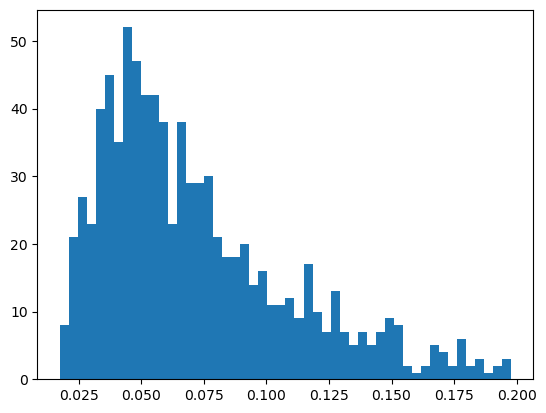

In [141]:
plt.hist(df_latest[df_latest['vacancy_rate'] < 0.2]['vacancy_rate'], bins = 50)

In [142]:
df_orig = df.copy()

In [143]:
# MAKE VALI DATA SECOND TO LAST YEAR; TEST DATA LAST YEAR; TRAIN FIRST 6
last_year = df['year'].max()
train = df[df['year'] < last_year - 4]
vali = df[df['year'] == last_year - 1]
test = df[df['year'] == last_year]

In [144]:
print('training sample - ', len(train))
print('validation sample - ', len(vali))
print('test sample - ', len(test))

training sample -  4663
validation sample -  836
test sample -  840


In [145]:
for yr in set(df['year'].values.tolist()):
    print(yr, len(df[df['year'] == yr]))

2016 820
2017 826
2018 836
2019 840
2009 750
2010 765
2011 770
2012 785
2013 791
2014 802
2015 815


In [146]:
print(len(df))
print(len(df_latest))

8800
871


In [147]:
# TESTING HAS SHOWN FAKE PREDS BEATS MODEL - WANNA SEE WHAT HAPPENS IF FAKE PRED IS A FEATURE
train['fake_pred'] = round(((train['average_home_value'] * (1 + train['home_val_growth_last_3_years']) - train['average_home_value']) + \
                     (
                        train['average_annual_rent'] * (1 + train['rent_growth_last_1_years']) +\
                        train['average_annual_rent'] * (1 + train['rent_growth_last_2_years']) +\
                        train['average_annual_rent'] * (1 + train['rent_growth_last_3_years'])
                     ))/train['average_home_value'], 4)

/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_92331/2596095845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['fake_pred'] = round(((train['average_home_value'] * (1 + train['home_val_growth_last_3_years']) - train['average_home_value']) + \


In [148]:
vali['fake_pred'] = round(((vali['average_home_value'] * (1 + vali['home_val_growth_last_3_years']) - vali['average_home_value']) + \
                     (
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_1_years']) +\
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_2_years']) +\
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_3_years'])
                     ))/vali['average_home_value'], 4)

/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_92331/1132831924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vali['fake_pred'] = round(((vali['average_home_value'] * (1 + vali['home_val_growth_last_3_years']) - vali['average_home_value']) + \


In [149]:
#X, Y SPLITS
ex_train = train.drop(columns = ['year', 'place', 'roi'])
ex_train_scaled = std_scl.fit_transform(ex_train)
why_train = train['roi']


ex_vali = vali.drop(columns = ['year', 'place', 'roi'])
ex_vali_scaled = std_scl.fit_transform(ex_vali)
why_vali = vali['roi']

ex_test = test.drop(columns = ['year', 'place', 'roi'])
ex_test_scaled = std_scl.fit_transform(ex_test)
why_test = test['roi']

In [150]:
mse = metrics.mean_squared_error
mae = metrics.mean_absolute_error

In [151]:
print('actuals mean - ', why_vali.mean())
print('actuals standard dev - ', why_vali.std())

actuals mean -  0.3233958133971292
actuals standard dev -  0.09878526930445224


In [152]:
# vali['average_home_value'] = vali['average_home_value'].astype('float')
# vali['home_val_growth_last_3_years'] = vali['home_val_growth_last_3_years'].astype('float')
# vali['average_annual_rent'] = vali['average_annual_rent'].astype('float')
# vali['rent_growth_last_1_years'] = vali['rent_growth_last_1_years'].astype('float')
# vali['rent_growth_last_2_years'] = vali['rent_growth_last_2_years'].astype('float')
# vali['rent_growth_last_3_years'] = vali['rent_growth_last_3_years'].astype('float')


In [153]:
print('rmse - ', m.sqrt(mse(why_vali, vali['fake_pred'])))
print('mae - ', mae(why_vali, vali['fake_pred']))
vali = vali.drop(columns = ['fake_pred'])

rmse -  0.08366455757236696
mae -  0.06512547846889953


In [154]:
# SCALE NON-PERCENTAGES
# std_scl = StandardScaler()
# train['average_annual_rent'] = std_scl.fit_transform(train[['average_annual_rent']])
# train['average_home_value'] = std_scl.fit_transform(train[['average_home_value']])
# train['total_population'] = std_scl.fit_transform(train[['total_population']])

# vali['average_annual_rent'] = std_scl.fit_transform(vali[['average_annual_rent']])
# vali['average_home_value'] = std_scl.fit_transform(vali[['average_home_value']])
# vali['total_population'] = std_scl.fit_transform(vali[['total_population']])

# test['average_annual_rent'] = std_scl.fit_transform(test[['average_annual_rent']])
# test['average_home_value'] = std_scl.fit_transform(test[['average_home_value']])
# test['total_population'] = std_scl.fit_transform(test[['total_population']])

QUICK NOTE THAT I USED TO INCLUDE LOGISTIC REGRESSION; RESULTS WERE POOR TO THE POINT OF NOT BEING WORTH FURTHER EXPLORATION

In [155]:
rf = ens.RandomForestRegressor(random_state=123)

# TRAIN/VALI
rf_fit = rf.fit(ex_train, why_train)
rf_preds = rf_fit.predict(ex_vali)
print('rmse - ', m.sqrt(mse(why_vali, rf_preds)))
print('mae - ', mae(why_vali, rf_preds))

# PERFORMANCE BEEN BAD SO WANNA SHPEEP TRAINING SCORES TOO - ARE WE OVER OR UNDER FITTING?
rf_train_preds = rf.fit(ex_train, why_train).predict(ex_train)
print('training rmse - ', m.sqrt(mse(why_train, rf_train_preds)))
print('training mae - ', mae(why_train, rf_train_preds))

rmse -  0.2075529524331766
mae -  0.17872058732057416
training rmse -  0.024021978017758988
training mae -  0.01725818207162771


/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_92331/3272181699.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x = rf_df['feature_importance'], y = rf_df['feature_names'], ci = None)


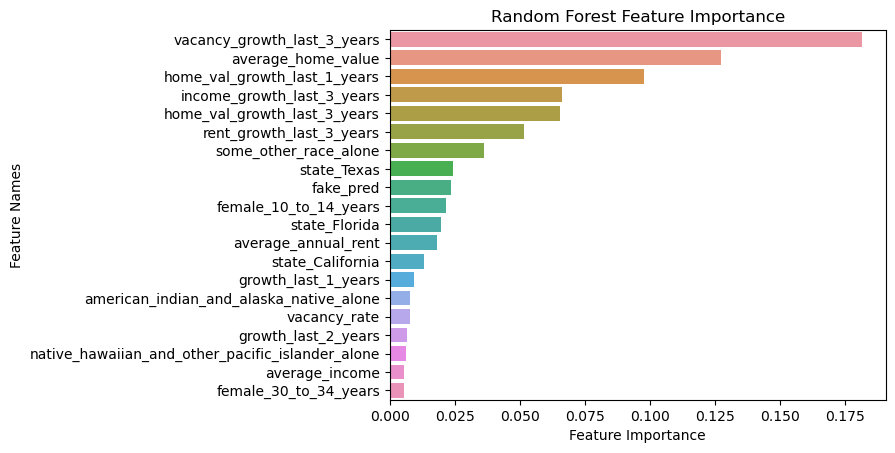

In [156]:
feature_names = ex_train.columns
importances = rf_fit.feature_importances_
data = {'feature_names': feature_names, 'feature_importance': importances}
rf_df = pd.DataFrame(data)
rf_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
rf_df = rf_df.head(20)

sns.barplot(x = rf_df['feature_importance'], y = rf_df['feature_names'], ci = None)

#ADD CHART LABELS
plt.title('Random Forest Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.savefig("feature_importance", bbox_inches = "tight")

In [157]:
%store -r rf_params

In [158]:
rf_params

{'rf__n_estimators': 50,
 'rf__max_depth': 30,
 'rf__criterion': 'friedman_mse',
 'pca__n_components': 18}

In [159]:
steps = [('pca', PCA(n_components = rf_params['pca__n_components'])), 
         ('rf', ens.RandomForestRegressor(n_estimators = rf_params['rf__n_estimators'], 
                                      max_depth = rf_params['rf__max_depth'],
                                      criterion = rf_params['rf__criterion']))]
model_rf = Pipeline(steps = steps)

# TRAIN/VALI
rf_fit = model_rf.fit(ex_train, why_train)
rf_preds_tuned = rf_fit.predict(ex_vali)
print('rmse - ', m.sqrt(mse(why_vali, rf_preds_tuned)))
print('mae - ', mae(why_vali, rf_preds_tuned))

# PERFORMANCE BEEN BAD SO WANNA SHPEEP TRAINING SCORES TOO - ARE WE OVER OR UNDER FITTING?
rf_train_preds_tuned = model_rf.fit(ex_train, why_train).predict(ex_train)
print('training rmse - ', m.sqrt(mse(why_train, rf_train_preds_tuned)))
print('training mae - ', mae(why_train, rf_train_preds_tuned))

rmse -  0.18962687192392866
mae -  0.15898235752259438
training rmse -  0.03748768338086723
training mae -  0.02631974584434627


In [160]:
%store -r ada_params

In [161]:
ada_params

{'n_estimators': 150, 'learning_rate': 1}

In [162]:
ada = ens.AdaBoostRegressor(n_estimators = ada_params['n_estimators'], learning_rate = ada_params['learning_rate'])
# TRAIN/VALI
ada_fit = ada.fit(ex_train, why_train)
ada_preds = ada_fit.predict(ex_vali)
print('rmse - ', m.sqrt(mse(why_vali, ada_preds)))
print('mae - ', mae(why_vali, ada_preds))
               
# PERFORMANCE BEEN BAD SO WANNA SHPEEP TRAINING SCORES TOO - ARE WE OVER OR UNDER FITTING?
ada_train_preds = ada.fit(ex_train, why_train).predict(ex_train)
print('training rmse - ', m.sqrt(mse(why_train, ada_train_preds)))
print('training mae - ', mae(why_train, ada_train_preds))

rmse -  0.15715380210607824
mae -  0.12869558851902477
training rmse -  0.08546507915640457
training mae -  0.06998511387922018


/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_92331/3200975213.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x = ada_df['feature_importance'], y = ada_df['feature_names'], ci = None)


Text(0, 0.5, 'Feature Names')

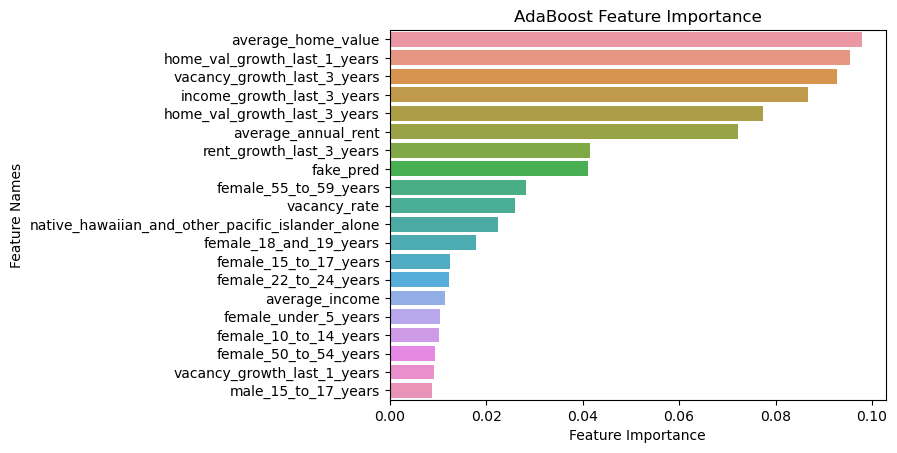

In [163]:
feature_names = ex_train.columns
importances = ada_fit.feature_importances_
data = {'feature_names': feature_names, 'feature_importance': importances}
ada_df = pd.DataFrame(data)
ada_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
ada_df = ada_df.head(20)

sns.barplot(x = ada_df['feature_importance'], y = ada_df['feature_names'], ci = None)

#ADD CHART LABELS
plt.title('AdaBoost Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
# plt.savefig("adaboost_fi_diag_chrom_level", bbox_inches = "tight")

In [164]:
%store -r xgboost_params

In [165]:
xgboost_params

{'scale_pos_weight': 1, 'max_depth': 7, 'eta': 0.1}

In [166]:
# XGBOOST IS BEING A CRYBABY ABOUT TYPES IDK WHY, BUT WHATEVER I'LL EXPLICITLY FIX LOL
ex_train['average_annual_rent'] = ex_train['average_annual_rent'].astype(float)
ex_train['average_home_value'] = ex_train['average_home_value'].astype(float)
# ex_train['average_income'] = ex_train['average_income'].astype(float)

ex_vali['average_annual_rent'] = ex_vali['average_annual_rent'].astype(float)
ex_vali['average_home_value'] = ex_vali['average_home_value'].astype(float)
ex_vali['average_income'] = ex_vali['average_income'].astype(float)


xg = XGBRegressor(scale_pos_weight = xgboost_params['scale_pos_weight'],
                   max_depth = xgboost_params['max_depth'], 
                   eta = xgboost_params['eta'])

# TRAIN/VALI
xg_fit = xg.fit(ex_train, why_train)
xg_preds = xg_fit.predict(ex_vali)
print('rmse - ', m.sqrt(mse(why_vali, xg_preds)))
print('mae - ', mae(why_vali, xg_preds))

# PERFORMANCE BEEN BAD SO WANNA SHPEEP TRAINING SCORES TOO - ARE WE OVER OR UNDER FITTING?
xg_train_preds = xg.fit(ex_train, why_train).predict(ex_train)
print('training rmse - ', m.sqrt(mse(why_train, xg_train_preds)))
print('training mae - ', mae(why_train, xg_train_preds))

rmse -  0.19903688027233898
mae -  0.16960345920100287
training rmse -  0.01957588892326455
training mae -  0.014729567439087833


/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_92331/1849121513.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x = xg_df['feature_importance'], y = xg_df['feature_names'], ci = None)


Text(0, 0.5, 'Feature Names')

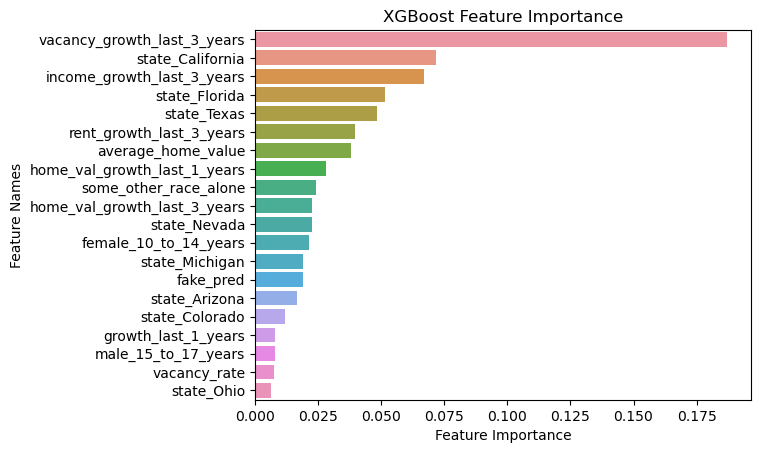

In [167]:
feature_names = ex_train.columns
importances = xg_fit.feature_importances_
data = {'feature_names': feature_names, 'feature_importance': importances}
xg_df = pd.DataFrame(data)
xg_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
xg_df = xg_df.head(20)

sns.barplot(x = xg_df['feature_importance'], y = xg_df['feature_names'], ci = None)

#ADD CHART LABELS
plt.title('XGBoost Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
# plt.savefig("adaboost_fi_diag_chrom_level", bbox_inches = "tight")

In [168]:
# SO MODEL PERFORMANCE NOT GREAT, BUT I WANNA SEE WHAT THE TOP PREDICTED AREAS WERE FOR FUN
# AFTER ALL, IF IT'S TYPICALLY OFF BUT THE VERY HIGH PREDS ARE MORE SOLID, THEN THIS ACTUALLY IS STILL USEFUL
# SINCE OUR GOAL IS TO USE THIS TO IDENTIFY TOP CANDIDATES
# RF WAS MOST PERFORMANT SO GOING TO BASE THIS ON THOSE PREDS

vali['predicted_roi'] = round(((vali['average_home_value'] * (1 + vali['home_val_growth_last_3_years']) - vali['average_home_value']) + \
                     (
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_1_years']) +\
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_2_years']) +\
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_3_years'])
                     ))/vali['average_home_value'], 4)

In [169]:
pred_check = vali.sort_values(by = 'predicted_roi', ascending = False)
pred_check = pred_check.drop(columns = [x for x in df.columns if x != 'place' and\
                                        x != 'year' and x != 'average_annual_rent' and\
                                        x != 'average_home_value' and x != 'total_population' and\
                                        'roi' not in x])


In [170]:
df_ec = vali.copy()
df_ec['error'] = round(df_ec['predicted_roi'] - df_ec['roi'], 3)

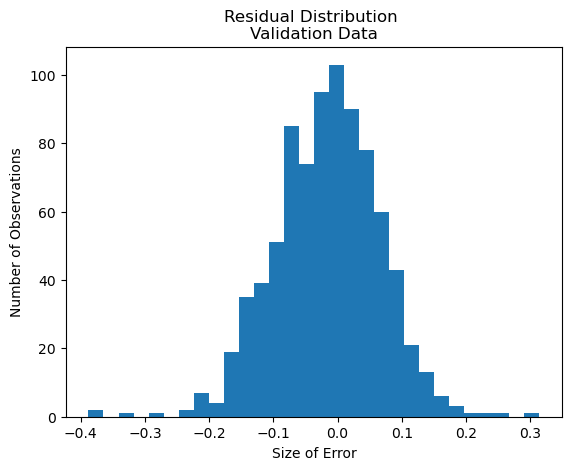

In [171]:
plt.hist(df_ec['error'], bins = 30)
plt.title("Residual Distribution \nValidation Data")
plt.xlabel("Size of Error")
plt.ylabel("Number of Observations")
plt.savefig("Model_Residuals")

CHECKING IN, NONE OF THE MODELS (OFF THE SHELF OR TUNED) ACTUALLY BEAT THE "DUMB" BASELINE SET WITH A SIMPLE LINEAR COMBINATION OF THE LAST THREE YEARS OF GROWTH PROJECTED TO THE NEXT THREE. 

HAVING SAID THAT, THE BASELINE MODEL ACTUALLY PERFORMS WELL, BEATING STANDARD DEVIATION OF THE VALIDATION SET'S ROI. THIS IMPLIES THAT IT DOES BETTER THAN PREDICTING THE SET'S AVERAGE (THIS IS HARDER THAN IT SOUNDS AS WE DON'T HAVE THE AVERAGE AHEAD OF TIME), SO THE "DUMB" MODEL ITSELF IS ACTUALLY A FAIRLY USEFUL TOOL. THIS IS SEEMINGLY CONFIRMED BY THE ERROR'S (SOMEWHAT) NORMAL DISTRIBUTION ABOUT 0.

NEXT, WE CHECK WITH A MORE "REAL WORLD" TEST. REALISTICALLY WE WOULD NOT BE BUYING AND SHORTING ON EVERY CITY'S REAL ESTATE MARKET, SO THE BETTER APPLICATION IS TO SEE WHAT WOULD HAVE HAPPENED IF WE HAD USED THE MODEL TO IDENTIFY TOP CANDIDATES IN THE LATEST YEAR OF TESTABLE DATA. I CONSIDER ANY CANDIDATE IDENTIFIED THAT WOULD HAVE PERFORMED BETTER THAN AVERAGE ACCEPTABLE (THRESHOLD IN CELL BELOW).

In [185]:
print(pred_check['roi'].mean())
print(pred_check['roi'].median())

0.3233958133971292
0.32120000000000004


In [186]:
pred_check.head(25)

,year,place,average_annual_rent,average_home_value,total_population,roi,predicted_roi
243026,2018,Homestead city - Florida,12805.44,205563.55,68424,0.4291,0.7427
242944,2018,Fountainebleau CDP - Florida,16295.28,212014.00,59833,0.4632,0.5992
243450,2018,Tamarac city - Florida,15071.64,178162.49,64748,0.5027,0.5839
241297,2018,Hemet city - California,11911.56,195330.78,84069,0.3378,0.5830
242190,2018,Commerce City city - Colorado,13604.04,298314.84,54795,0.4032,0.5799
241718,2018,Pittsburg city - California,17344.68,376490.16,70492,0.4145,0.5790
243120,2018,Lauderhill city - Florida,13437.12,162409.51,71328,0.6239,0.5521
243129,2018,Lehigh Acres CDP - Florida,10427.40,152609.59,119205,0.5387,0.5509
239962,2018,Avondale city - Arizona,11496.96,201756.90,83392,0.4560,0.5500
243085,2018,Kissimmee city - Florida,11376.24,179173.48,69833,0.4643,0.5486


NO WOULD-BE CANDIDATES FALL BELOW OUR THRESHOLD, SO WHILE THE MODEL ISN'T PERFECT IT WOULD HAVE IDENTIFIED QUALITY CANDIDATES FROM WHICH TO CHOOSE (AKA IT'S USEFUL). 

HAVING SAID THAT, IT CONSISTENTLY OVERESTIMATED THESE CANDIDATES' PERFORMANCE. I NEXT CHECK MEAN PREDICTED ROI VERSUS MEAN ROI TO SEE IF THIS IS A WIDESPREAD PROBLEM. IN ADDITION, I CHECK THE TOP ACTUAL PERFORMERS TO SEE IF HOW THE MODEL WOULD HAVE RATED THEM (IT'S MORE IMPORTANT THAT IT'S HIGH RATINGS AREN'T ACTUALLY BAD, BUT IDEALLY ACTUALLY GOOD PERFORMERS WOULD NOT BE RATED AS BAD EITHER). FINALLY, I CHECK TO SEE HOW MUCH OVERLAP THERE WOULD HAVE BEEN BETWEEN TOP CANDIDATES IDENTIFIED AND TOP PERFORMERS.

In [189]:
print('predicted - ', pred_check['predicted_roi'].mean())
print('actual - ', pred_check['roi'].mean())

predicted -  0.30709425837320575
actual -  0.3233958133971292


In [190]:
#PRETTY CLOSE!

In [191]:
pred_check.sort_values(by = 'roi', ascending = False).head(25)

,year,place,average_annual_rent,average_home_value,total_population,roi,predicted_roi
244331,2018,Caldwell city - Idaho,8265.60,142924.74,53205,0.8646,0.4764
243310,2018,Pine Hills CDP - Florida,10138.20,130756.86,75575,0.7808,0.5078
244438,2018,Nampa city - Idaho,8836.44,163784.54,91663,0.6862,0.4727
249802,2018,Flint city - Michigan,5908.32,47133.92,97161,0.6543,0.3169
243120,2018,Lauderhill city - Florida,13437.12,162409.51,71328,0.6239,0.5521
243182,2018,Miami Gardens city - Florida,12626.88,189457.86,112913,0.6142,0.5219
244426,2018,Meridian city - Idaho,11963.64,258787.66,97008,0.5873,0.3556
255060,2018,Utica city - New York,7521.00,117217.11,60675,0.5846,0.2108
243444,2018,Sunrise city - Florida,16504.92,188047.93,93199,0.5770,0.5208
249754,2018,Detroit city - Michigan,7401.36,75133.92,677155,0.5691,0.5181


In [193]:
[place for place in pred_check.head(25)['place'].values.tolist() if \
 place in pred_check.sort_values(by = 'roi', ascending = False).head(25)['place'].values.tolist()]

['Lauderhill city - Florida',
 'Lehigh Acres CDP - Florida',
 'Miami Gardens city - Florida',
 'Sunrise city - Florida',
 'Detroit city - Michigan']

SO, 2 OF THE TOP PERFORMERS HAD A BELOW AVERAGE PREDICTION, AND 5 CITIES WOULD HAVE BEEN TOP 25 IN BOTH PREDICTED AND ACTUAL ROI. GIVEN THAT THE TOP PREDICTED ALL WERE ABOVE AVERAGE, I'D CONCLUDE THAT WHILE THERE IS DEFINITELY ROOM FOR IMPROVEMENT, THE REAL ESTATE INVESTMENT MODEL WOULD HAVE DONE MEANINGFULLY BETTER THAN RANDOM.

PUT ANOTHER WAY, WHILE I WOULD NOT RECOMMEND USING IT BLINDLY TO PICK A CITY FOR INVESTMENT, IT'S A USEFUL TOOL FOR NARROWING DOWN THE POOL OF CANDIDATES. WHILE YOU MAY MISS OUT ON THE TOP POSSIBLE INVESTMENT OPPORTUNITY, IT'S PREVIOUS PERFORMANCE SUGGESTS YOU'D BE LIKELY TO HAVE A SOLID PICK.

FOR NEXT IMMEDIATE STEPS, I MAKE THE DATA AVAILABLE IN AN API. LONG-TERM, FURTHER RESEARCH ON A MACHINE-LEARNING-ENGINEERED SOLUTION TO BEAT OUR HEURISTIC WOULD BE IDEAL.

In [175]:
df_latest = df_latest.dropna()
df_latest = df_latest.drop(columns = [x for x in df_latest.columns if 'state_' in x])

In [176]:
df_latest['pred'] = round(((df_latest['average_home_value'] * (1 + df_latest['home_val_growth_last_3_years']) - df_latest['average_home_value']) + \
                     (
                        df_latest['average_annual_rent'] * (1 + df_latest['rent_growth_last_1_years']) +\
                        df_latest['average_annual_rent'] * (1 + df_latest['rent_growth_last_2_years']) +\
                        df_latest['average_annual_rent'] * (1 + df_latest['rent_growth_last_3_years'])
                     ))/df_latest['average_home_value'], 4)

In [177]:
df_latest.to_csv("latest_yrs_w_preds_city.csv")